# Reversal / Momentum - Time Horizon

In this notebook, we explore the relationship between time horizon and return predictability—specifically, how reversal effects tend to dominate at shorter horizons, while momentum effects emerge over longer horizons. To illustrate this phenomenon, we will analyze 4-hour cryptocurrency price data from Binance, covering the period January 2020 to December 2022. The flow of events will be as follow:

1. Download the price data (from Binance since 01/2020 to 12/2022) and compute returns based on it, stored in `ret`.
2. Use `ret` to generate rank-demeaned-normalized XS reversal strategies at 4,8,12,16,20, and 24 hour frequencies.
3. IE. for the 12 hour strategy, you will use the average return in the last three 4-hour bars to form a rank-demeaned-normalised XS portfolio and hold for the 4 hours.
4. Compute the Sharpe ratios of the reversal strategy at these different horizons.
5. At what horizons do you observe reversal vs. momentum?
6. The first bar typically contains the most reversal. "Skip" the first bar by lagging your portfolio by one 4h bar (similar to how UMD does at the monthly frequency). This should strengthen any momentum you see.

In [1]:
# Download the python-binance package if you haven't already
#!pip install python-binance

In [2]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Step 1: Data Preparation

Download the price data (from Binance since 01/2020 to 12/2022) and compute returns based on it, stored in `ret`. Import required libraries (ensure these are installed)
- import pandas as pd
- from datetime import datetime
- from binance.client import Client  # assuming bnb_client is an alias or custom wrapper

*Note: You may need to install python-binance: pip install python-binance*

#### Initialize Binance client
Replace with your API keys if needed (for public data, keys are optional). If you're in the US, use **"client = bnb_client(tld='US')"** here, else use **"client = bnb_client()"** instead

In [3]:
client = bnb_client()
###  if you're in the US, use: 
### "client = bnb_client(tld='US')" here instead

def get_binance_px(symbol,freq,start_ts = '2020-01-01'):
  """ Fetch historical kline/candlestick data from Binance.
  Parameters:
  - symbol (str): Trading pair, e.g., 'BTCUSDT'
  - freq (str): Kline interval, e.g., '4h', '1d', '1m'
  - start_ts (str): Start date in 'YYYY-MM-DD' format
    
  Returns:
  - pd.DataFrame: DataFrame with timestamp index and OHLCV data
  """
  data = client.get_historical_klines(symbol,freq,start_ts)
  columns = [
    'open_time','open','high','low','close',
    'volume','close_time','quote_volume','num_trades',
    'taker_base_volume','taker_quote_volume','ignore'
  ]
  data = pd.DataFrame(data,columns = columns)
  
  # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
  data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
  data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
  return data 

# Define universe of cryptocurrency pairs
univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

# Set frequency (e.g., 4-hour candles)
freq = '4h'
px = {}
for x in univ:
  data = get_binance_px(x,freq)
  px[x] = data.set_index('open_time')['close']

# Combine into a single DataFrame and convert to float
px = pd.DataFrame(px).astype(float)

# Reindex to ensure regular time intervals (fill missing with NaN)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change() # Calculate simple returns

/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_14057/916111364.py:43: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = px.pct_change() # Calculate simple returns


In [4]:
ret.tail()

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
2026-01-20 08:00:00,0.000450,-0.004319,-0.022404,-0.005546,-0.010363,-0.015570,0.0
2026-01-20 12:00:00,-0.005854,-0.024724,0.004472,-0.008053,-0.006065,-0.010204,0.0
2026-01-20 16:00:00,-0.010577,-0.012034,-0.019477,-0.010637,-0.007823,-0.013918,0.0
2026-01-20 20:00:00,-0.014467,-0.018892,-0.004824,-0.012839,-0.006518,-0.008364,0.0
2026-01-21 00:00:00,0.007208,0.007691,0.021101,-0.007679,0.003280,0.030575,0.0


### Step 2: Strategy Construction

Use `ret` to generate rank-demeaned-normalized XS reversal strategies at 4,8,12,16,20, and 24 hour frequencies. What we notice is that we tend to get reversal at horizons of <=8 hours. Momentum exists at longer horizons.

In [8]:
strats = {}

# Since the data is in 4-hour frequency, we use horizons of 1 to 6 (i.e., 4h to 24h)
for hor in [1,2,3,4,5,6]:
  # Step 1: Rolling average return over the past `hor` periods
  avg_ret = ret.rolling(hor,min_periods=1).mean().rank(1)
  
  # Step 2: Demean cross-sectionally (zero-mean portfolio)
  avg_ret = avg_ret.subtract(avg_ret.mean(1),0)
  
  # Step 3: Normalize by sum of absolute values → dollar-neutral weights
  avg_ret = avg_ret.divide(avg_ret.abs().sum(1),0)
  
  # Step 4: Shift weights by 1 period and apply to next-period returns
  # This implements a reversal strategy: bet against recent winners/losers
  strats[hor] = (avg_ret.shift()*ret).sum(1)
strats = pd.DataFrame(strats)

In [9]:
# Calculate annualized Sharpe ratios for each strategy
sr = strats.mean()/strats.std()*np.sqrt(252*24/4)
sr

1   -0.410659
2    0.139714
3    0.828502
4    1.289611
5    1.287325
6    1.137425
dtype: float64

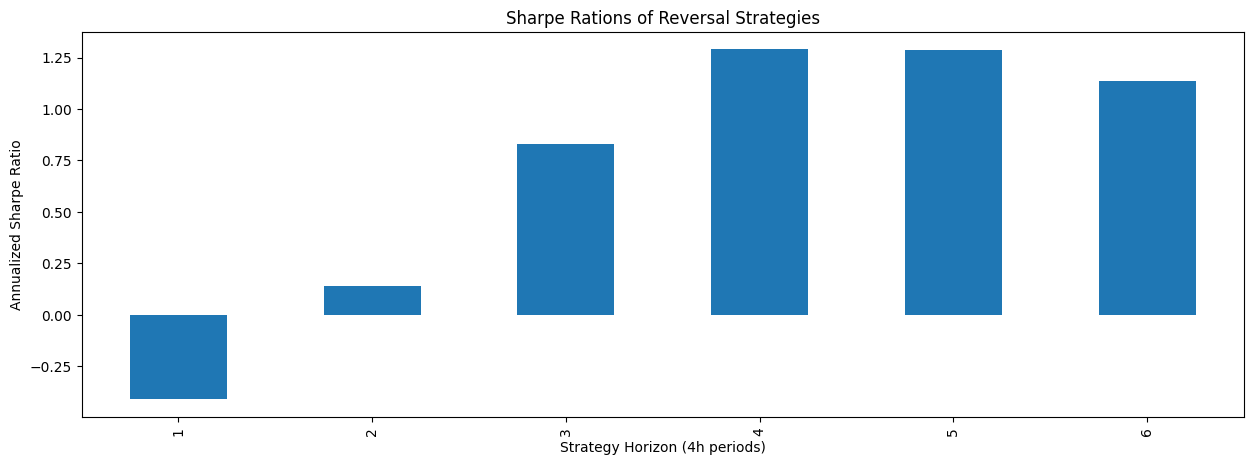

In [10]:
# Expand the chart to see drawdowns
sr.plot(kind='bar')
plt.title("Sharpe Rations of Reversal Strategies")
plt.xlabel("Strategy Horizon (4h periods)")
plt.ylabel("Annualized Sharpe Ratio") 
plt.gcf().set_size_inches(15, 5) # Increase the size of the plot for better visibility
plt.show()

Let us adjust the lag in our strategy and observe the change in our Annualised Sharpe Ratio across all strategies

In [11]:
strats_lag = {}
for hor in [1,2,3,4,5,6]:
  avg_ret = ret.rolling(hor,min_periods=1).mean().rank(1) # Rank the returns
  avg_ret = avg_ret.subtract(avg_ret.mean(1),0) # Demean cross-sectionally
  avg_ret = avg_ret.divide(avg_ret.abs().sum(1),0) # Normalize to dollar-neutral weights
  strats_lag[hor] = (avg_ret.shift(2)*ret).sum(1) # Introduce the lag of 2 periods
strats_lag = pd.DataFrame(strats_lag)

# Calculate annualized Sharpe ratios for each strategy
sr = strats_lag.mean()/strats_lag.std()*np.sqrt(252*24/4)
sr

1    0.476049
2    1.298512
3    1.731900
4    1.612326
5    1.292129
6    1.568247
dtype: float64

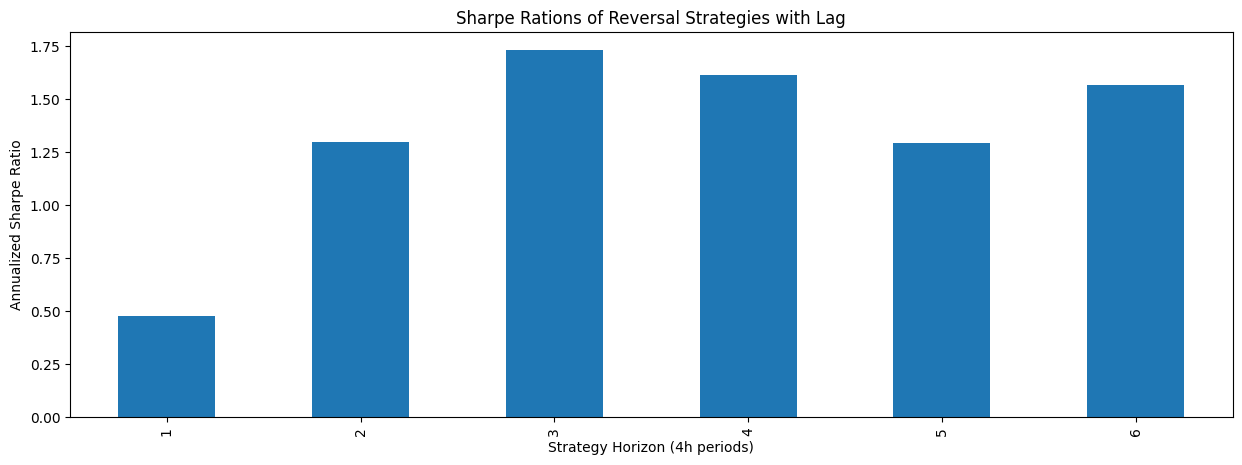

In [12]:
# Expand the chart to see drawdowns
sr.plot(kind='bar')
plt.title("Sharpe Rations of Reversal Strategies with Lag")
plt.xlabel("Strategy Horizon (4h periods)")
plt.ylabel("Annualized Sharpe Ratio") 
plt.gcf().set_size_inches(15, 5) # Increase the size of the plot for better visibility
plt.show()

Generalised function for the above

In [13]:
def reversal_momentum_sharpe_plot(ret, lag):
    """
    Implements a reversal or momentum strategy based on the specified horizon and lag.
    
    Parameters:
    - ret (pd.DataFrame): DataFrame of asset returns
    - hor (int): Horizon for calculating average returns
    - lag (int): Lag period to shift the weights (1 for reversal, >1 for lagged strategies)
    
    Returns:
    - outputs the sharpe ratio plot of the strategy returns
    """
    strats_lag = {}
    for hor in [1,2,3,4,5,6]:
      avg_ret = ret.rolling(hor,min_periods=1).mean().rank(1)
      avg_ret = avg_ret.subtract(avg_ret.mean(1),0)
      avg_ret = avg_ret.divide(avg_ret.abs().sum(1),0)
      strats_lag[hor] = (avg_ret.shift(lag)*ret).sum(1)
    strats_lag = pd.DataFrame(strats_lag)
    # Calculate annualized Sharpe ratios for each strategy
    sr = strats_lag.mean()/strats.std()*np.sqrt(252*24/4)
    
    # Expand the chart to see drawdowns
    sr.plot(kind='bar')
    plt.title(f"Sharpe Rations of Reversal/Lagged Strategies with Lag {lag}")
    plt.xlabel("Strategy Horizon (4h periods)")
    plt.ylabel("Annualized Sharpe Ratio") 
    plt.gcf().set_size_inches(15, 3) # Increase the size of the plot for better visibility
    plt.show()

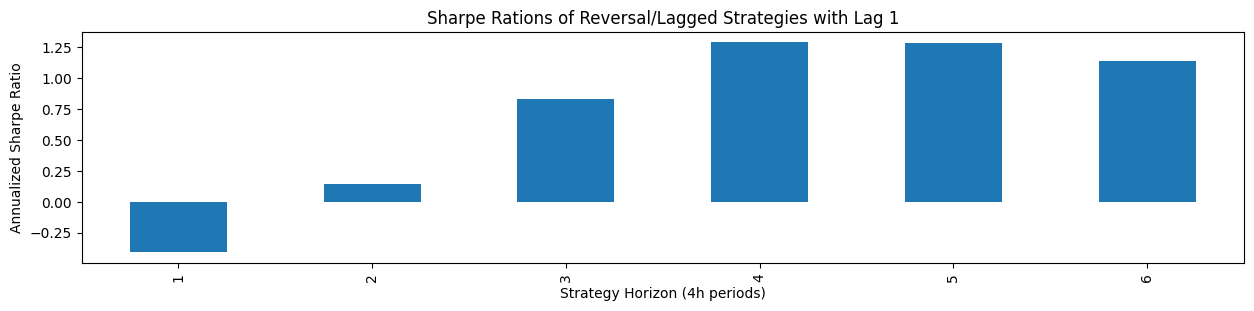

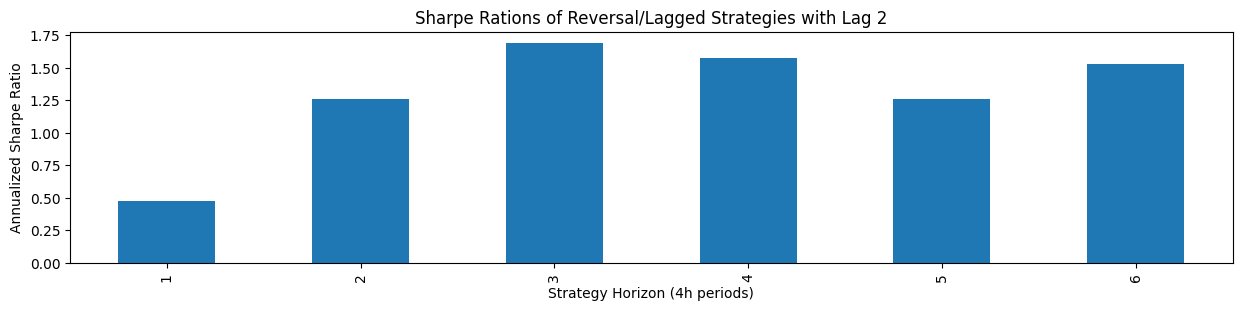

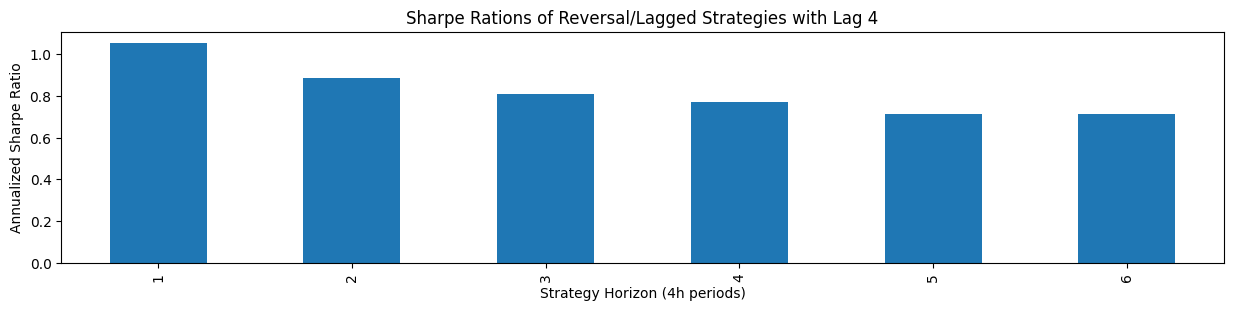

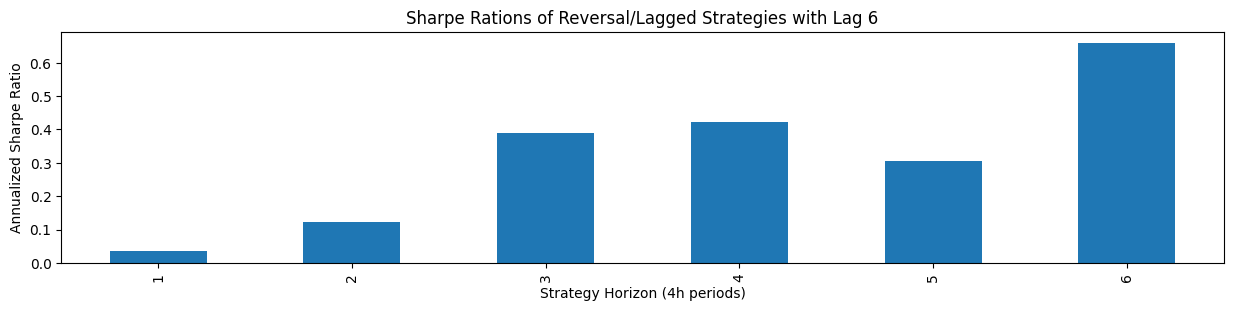

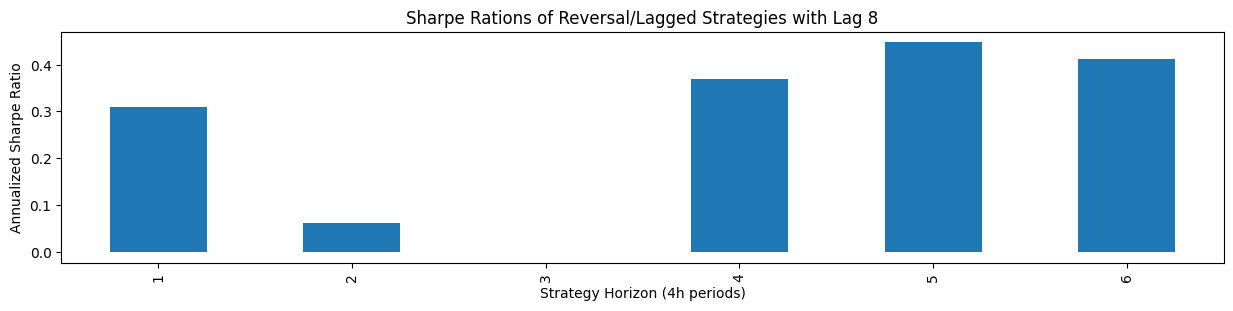

In [14]:
reversal_momentum_sharpe_plot(ret, lag=1)  # Reversal strategy
reversal_momentum_sharpe_plot(ret, lag=2)  # Lagged strategy
reversal_momentum_sharpe_plot(ret, lag=4)  # Lagged strategy
reversal_momentum_sharpe_plot(ret, lag=6)  # Lagged strategy
reversal_momentum_sharpe_plot(ret, lag=8)  # Lagged strategy

As seen above, our SR increase as we add some lag to the above reversal strategy. However, too much of a lag would result in our strategies' SR falling as shown in the charts above.